![](https://i.pinimg.com/564x/79/7b/06/797b06f0efa5afa161add7abaac817dd.jpg)

# Magnetometer Calibration

Kevin Walchko, Phd

30 May 2020

---

To calibrate a magnetometer, you need to get readings from all directions in 3D space. Ideally, when you plot the readings out, you should get a perfect sphere centered at (0,0,0). However, due to misalignments, offset, etc ... you end up with ellipsoids centered at some biased location.

Here we are going to try and get enough readings to estimate these errors and properly calibrate the sensor. We will load in a pre-recorded data set, where the sensor was tumbled around and calibrate it.

## Errors

![](soft-and-hard.png)

- **Soft iron errors:** caused by distortion of the Earth's magnetic field due to materials in the environment. Think of it like electricity - the magnetic field is looking for the easiest path to get to where it is going. Since magnetic fields can flow more easily through ferromagnetic materials than air, more of the field will flow through the ferromagnetic material than you would expect if it were just air. This distortion effect causes the magnetic field lines to be bent sometimes quite a bit. Note that unlike hard iron interference which is the result of materials which actually have a magnetic field of their own, soft iron interference is caused by non-magnetic materials distorting the Earth's magnetic field. This type of interference has a squishing effect on the magnetic data circle turning it into more of an ellipsoid shape. The distortion in this case depends on the direction that the compass is facing. Because of this, the distortion cannot be calibrated out with a simple offset
- **Hard iron errors:** caused by static magnetic fields associated with the enviornment. For example, this could include any minor (or major) magnetism in the metal chassis or frame of a vehicle, any actual magnets such as speakers, etc... This interference pattern is unique to the environment but is constant. If you have your compass in an enclosure that is held together with metal screws, these relatively small amounts of ferromagnetic material can cause issues. If we consider the magnetic data circle, hard iron interference has the effect of shifting the entire circle away from the origin by some amount. The amount is dependent on any number of different factors and can be very large. 

## References

- Ozyagcilar, T. ["Calibrating an eCompass in the Presence of Hard and Soft-iron Interference."](AN4246.pdf) Freescale Semiconductor Ltd. 1992, pp. 1-17.
- Teslabs: [Magnetometer Calibration](https://teslabs.com/articles/magnetometer-calibration/)
- ThePoorEngineer: [Calibrating the Magnetometer](https://www.thepoorengineer.com/en/calibrating-the-magnetometer/)
- Mathworks: [magcal](https://www.mathworks.com/help/fusion/ref/magcal.html#mw_34252c54-1f78-46b9-8c30-1a2b7351b0ce)

In [14]:
import numpy as np 
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

from scipy import linalg
# import sys
from squaternion import Quaternion
# import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

from math import radians as deg2rad
from math import degrees as rad2deg
from slurm import storage
from collections import deque
from datetime import datetime
# import os
from pprint import pprint

In [2]:
!ls -alh *.pickle

-rw-rw-r-- 1 kevin kevin 171K Aug 30 15:46 lis3mdl-cal-data.pickle


In [35]:
# let's load in some data and have a look at what we have
def condition(data):
    m = deque()
    dt = deque()
    start = data[0]["timestamp"]
    stop = data[-1]["timestamp"]
    hz = len(data)/(stop-start)
    print(f">> datarate: {hz:.1f}Hz")
    for d in data:
        m.append(d["m"])
    return np.array(m)
    
fname = "lis3mdl-cal-data.pickle"
# fname = "lis3mdl-cal-data.pickle.10hz"

data = storage.read(fname, "pickle")
Bpp = condition(data)

print(f">> data: {Bpp.shape}")

>> datarate: 17.5Hz
>> data: (3797, 3)


In [36]:
uT = 50.8862

In [37]:
def plotMagnetometer(data):
    x = [v[0] for v in data]
    rx = (max(x)-min(x))/2
    cx = min(x)+rx
    
    y = [v[1] for v in data]
    ry = (max(y)-min(y))/2
    cy = min(y)+ry
    
    z = [v[2] for v in data]
    rz = (max(z)-min(z))/2
    cz = min(z)+rz
    
    alpha = 0.1
    u = np.linspace(0, 2 * np.pi, 100)
    
    plt.plot(rx*np.cos(u)+cx, ry*np.sin(u)+cy,'-r',label='xy')
    plt.plot(x,y,'.r',alpha=alpha)
    
    plt.plot(rx*np.cos(u)+cx, rz*np.sin(u)+cz,'-g',label='xz')
    plt.plot(x,z,'.g',alpha=alpha)
    
    plt.plot(rz*np.cos(u)+cz, ry*np.sin(u)+cy,'-b',label='zy')
    plt.plot(z,y, '.b',alpha=alpha)
    
    plt.title(f"CM:({cx:.1f}, {cy:.1f}, {cz:.1f}) uT  R:({rx:.1f}, {ry:.1f}, {rz:.1f}) uT")
    plt.xlabel('$\mu$T')
    plt.ylabel('$\mu$T')
    plt.grid(True);
    plt.axis('equal')
    plt.legend();

In [38]:
def magcal(Bp, uT=None):
    """
    Modelled after the matlab function: magcal(D) -> A, b, expmfs
    inputs:
      Bp: data points
      uT: expected field strength for longitude/altitude. If None
          is given, then automatically calculated and used
    returns:
      A: soft-iron 3x3 matrix of scaling
      b: hard-iron offsets
      expmfs: expected field strength"""
    Y = np.array([v[0]**2+v[1]**2+v[2]**2 for v in Bp])
    X = np.hstack((Bp,np.ones((Bp.shape[0],1))))
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(Y))
    b=0.5*beta[:3]
    
    # expected mag field strength
    expmfs=np.sqrt(beta[3]+b[0]**2+b[1]**2+b[2]**2)
    
    if uT is None:
        uT = expmfs
    
    x = [v[0] for v in Bp]
    rx = (max(x)-min(x))/2

    y = [v[1] for v in Bp]
    ry = (max(y)-min(y))/2

    z = [v[2] for v in Bp]
    rz = (max(z)-min(z))/2
    
    A = np.diag([uT/rx,uT/ry,uT/rz])
    return A,b,expmfs

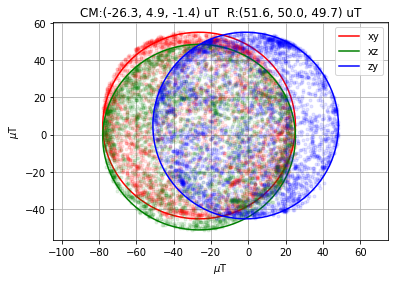

In [39]:
# Raw uncalibrated values - you can see the hard-iron offsets
# and the soft-iron ellipses
plotMagnetometer(Bpp)

>> soft-iron correction:
[[0.967 0.    0.   ]
 [0.    0.998 0.   ]
 [0.    0.    1.004]]
>> hard-iron offset: [-26.806   5.076  -1.114]uT   expmfs: 49.9uT


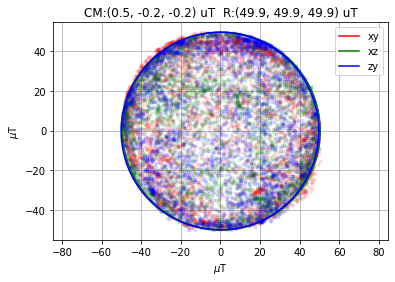

In [40]:
# calibrated w/o expected field strength
A,vv,bb = magcal(Bpp)
print(f">> soft-iron correction:\n{A}")
print(f">> hard-iron offset: {vv}uT   expmfs: {bb:.1f}uT")
plotMagnetometer((Bpp-vv).dot(A))

>> soft-iron correction:
[[0.985 0.    0.   ]
 [0.    1.018 0.   ]
 [0.    0.    1.023]]
>> hard-iron offset: [-26.806   5.076  -1.114]uT   expmfs: 49.9uT


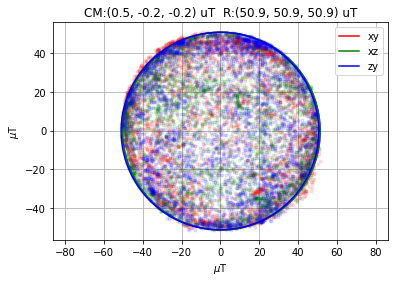

In [41]:
# calibrated with expected field strength - it only changes
# the radius of the circles
A,vv,bb = magcal(Bpp,uT)
print(f">> soft-iron correction:\n{A}")
print(f">> hard-iron offset: {vv}uT   expmfs: {bb:.1f}uT")
plotMagnetometer((Bpp-vv).dot(A))

# Save Parameters

In [42]:
M = np.vstack((A,vv))
mm = np.resize(M, (1, 12))[0].tolist()

params = {}
params["lis3mdl"] = {}
params["lis3mdl"]["timestamp"] = datetime.now()
params["lis3mdl"]["mag"] = {"data": mm, "shape": M.shape, "dtype": str(M.dtype)}

pprint(params)

# storage.write("lis3mdl-mag.yaml", params)

{'lis3mdl': {'mag': {'data': [0.985461025757147,
                              0.0,
                              0.0,
                              0.0,
                              1.0175752751717082,
                              0.0,
                              0.0,
                              0.0,
                              1.0232575470977223,
                              -26.806334214909334,
                              5.075539645023792,
                              -1.1136819149174713],
                     'dtype': 'float64',
                     'shape': (4, 3)},
             'timestamp': datetime.datetime(2020, 8, 30, 16, 4, 37, 940112)}}


In [43]:
storage.write("lis3mdl-mag.yaml", params)

In [44]:
!cat lis3mdl-mag.yaml

lis3mdl:
  mag:
    data:
    - 0.985461025757147
    - 0.0
    - 0.0
    - 0.0
    - 1.0175752751717082
    - 0.0
    - 0.0
    - 0.0
    - 1.0232575470977223
    - -26.806334214909334
    - 5.075539645023792
    - -1.1136819149174713
    dtype: float64
    shape:
    - 4
    - 3
  timestamp: 2020-08-30 16:04:37.940112


In [45]:
p = storage.read("lis3mdl-mag.yaml")
for k,v in p["lis3mdl"].items():
    if isinstance(v, dict):
        print(f"[{k}]")
        for kk, vv in v.items():
            if kk == "data":
                vv = np.array(vv, dtype=np.float64)
                vv.resize((4,3))
                print(f"- {kk}: {vv}")
            else:
                print(f"   => {kk}: {vv}")
    else:
        print(f"[{k}]: {v}")

[mag]
- data: [[  0.985   0.      0.   ]
 [  0.      1.018   0.   ]
 [  0.      0.      1.023]
 [-26.806   5.076  -1.114]]
   => dtype: float64
   => shape: [4, 3]
[timestamp]: 2020-08-30 16:04:37.940112
